In [1]:
import math
import torch
import gpytorch


In [75]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.cat((torch.linspace(0, 1, 15), torch.linspace(2, 3, 15)))
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04) + 5

In [76]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [77]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(50):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    print(f"Iter {i}, loss {loss}")

Iter 0, loss 2.4320855140686035
Iter 1, loss 2.2527801990509033
Iter 2, loss 2.0990278720855713
Iter 3, loss 1.968584418296814
Iter 4, loss 1.8590099811553955
Iter 5, loss 1.767817735671997
Iter 6, loss 1.692566156387329
Iter 7, loss 1.6308887004852295
Iter 8, loss 1.5804616212844849
Iter 9, loss 1.5389320850372314
Iter 10, loss 1.50387704372406
Iter 11, loss 1.4728960990905762
Iter 12, loss 1.4438865184783936
Iter 13, loss 1.4153752326965332
Iter 14, loss 1.3866757154464722
Iter 15, loss 1.3577842712402344
Iter 16, loss 1.3291207551956177
Iter 17, loss 1.3012659549713135
Iter 18, loss 1.2747554779052734
Iter 19, loss 1.249965786933899
Iter 20, loss 1.2270740270614624
Iter 21, loss 1.2060786485671997
Iter 22, loss 1.1868592500686646
Iter 23, loss 1.1692488193511963
Iter 24, loss 1.1530970335006714
Iter 25, loss 1.138291835784912
Iter 26, loss 1.1247572898864746
Iter 27, loss 1.1124125719070435
Iter 28, loss 1.101137399673462
Iter 29, loss 1.0907530784606934
Iter 30, loss 1.081029415130

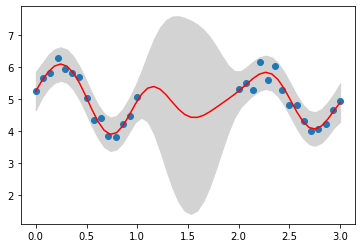

In [78]:
import matplotlib.pyplot as plt

model.eval()
likelihood.eval()

with torch.no_grad():
    xs = torch.linspace(0, 3, 50)
    preds = likelihood(model(xs))
    lower, upper = preds.confidence_region()
    plt.fill_between(xs, lower, upper, color="lightgrey")
    plt.plot(xs, preds.mean, color="red")
    plt.scatter(train_x, train_y)

In [81]:
from scipy.stats import wasserstein_distance

wasserstein_distance([0, 1], [0, 1], [0.5, 0.5], [0.25, 0.75])

0.0